# Procesamiento de lenguaje natural con NLTK
> Analísis sentimental sobre reviews de Amazon

- toc: false 
- badges: true
- comments: false
- categories: [NLP, naive_bayes]
- image: images/vectorizer.png

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
#nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"C:\Users\pablo\Documents\Data_Science\amazon_alexa.tsv", sep ="\t")

In [3]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df.sample(10)

,rating,date,variation,verified_reviews,feedback
1211,5,28-Jul-18,Black Spot,no problem,1
2510,5,30-Jul-18,Black Dot,,1
2984,4,30-Jul-18,White Dot,Its Great. Lots Of Fun!!,1
1848,5,28-Jul-18,Black Plus,Works great in my large open room,1
2187,5,30-Jul-18,Configuration: Fire TV Stick,,1
965,5,29-Jul-18,Charcoal Fabric,I have been wanting one of these for a while n...,1
1300,1,22-Jul-18,Black Spot,Product forces user to review Alexa Things to ...,0
637,5,28-May-18,Black,Arrived on time and works amazing!!!,1
1450,2,30-Jul-18,Black Show,Thought it would be more powerful and have a l...,0
84,4,30-Jul-18,Charcoal Fabric,Works fine!!,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [6]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


## EDA

In [7]:
df.isna().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [8]:
df.groupby("feedback").sum()

,rating
feedback,
0,353
1,13706


In [9]:
df.groupby("rating").count()

,date,variation,verified_reviews,feedback
rating,,,,
1,161,161,161,161
2,96,96,96,96
3,152,152,152,152
4,455,455,455,455
5,2286,2286,2286,2286


array([[<AxesSubplot:title={'center':'rating'}>,
        <AxesSubplot:title={'center':'feedback'}>]], dtype=object)

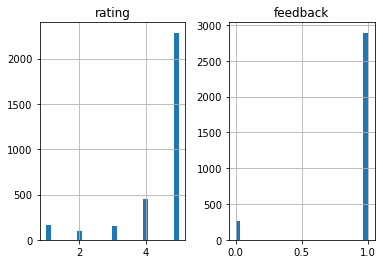

In [10]:
df.hist(bins=30)

This dataset is higly unvalanced

In [11]:
df["length"] = df["verified_reviews"].apply(len)

<AxesSubplot:ylabel='Frequency'>

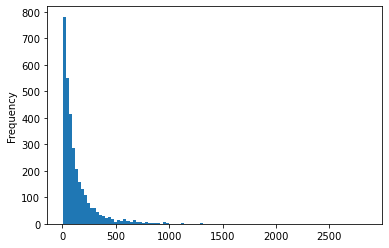

In [12]:
df["length"].plot(bins=100, kind="hist")

In [13]:
df["length"].describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

In [14]:
df[df["length"] > 1500]

,rating,date,variation,verified_reviews,feedback,length
563,3,12-Jun-18,Black,I received my Echo Dot today in good condition...,1,1954
1322,5,21-Jul-18,Black Spot,I got this on Prime day and figured I'd see wh...,1,2393
1383,3,17-Jul-18,Black Spot,This is 1 of 6 echo devices in the house and i...,1,1833
1996,2,21-Jul-18,Black Plus,I have been thinking about getting this for a ...,0,1686
2016,5,20-Jul-18,Black Plus,Incredible piece of technology.I have this rig...,1,2851
2234,5,30-Jul-18,Configuration: Fire TV Stick,Recently cut the cord on cable television. Nee...,1,1564


In [15]:
df[df["length"] == 2851]["verified_reviews"].iloc[0]

"Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It's no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This order came with a free Phi

In [16]:
df[df["length"] < 3]

,rating,date,variation,verified_reviews,feedback,length
60,5,30-Jul-18,Heather Gray Fabric,😍,1,1
85,5,30-Jul-18,Heather Gray Fabric,,1,1
183,3,29-Jul-18,Heather Gray Fabric,,1,1
219,5,29-Jul-18,Sandstone Fabric,,1,1
374,1,26-Jul-18,Black,,0,1
...,...,...,...,...,...,...
3114,3,30-Jul-18,Black Dot,,1,1
3120,5,30-Jul-18,Black Dot,,1,1
3123,4,30-Jul-18,Black Dot,,1,1
3126,5,30-Jul-18,Black Dot,,1,1


In [17]:
positive = df[df["feedback"] == 1]

In [18]:
negative = df[df["feedback"] == 0]

<AxesSubplot:xlabel='feedback', ylabel='count'>

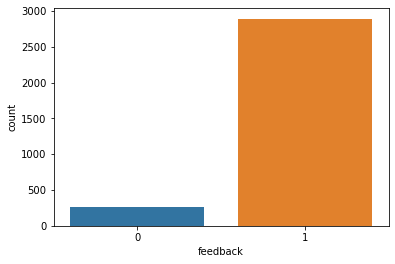

In [19]:
sns.countplot(x= df["feedback"], label = "Count")

<AxesSubplot:xlabel='rating', ylabel='count'>

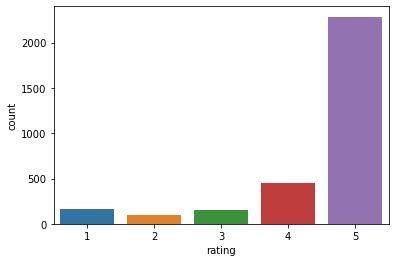

In [20]:
sns.countplot(x= df["rating"], data = df)

<AxesSubplot:xlabel='variation', ylabel='rating'>

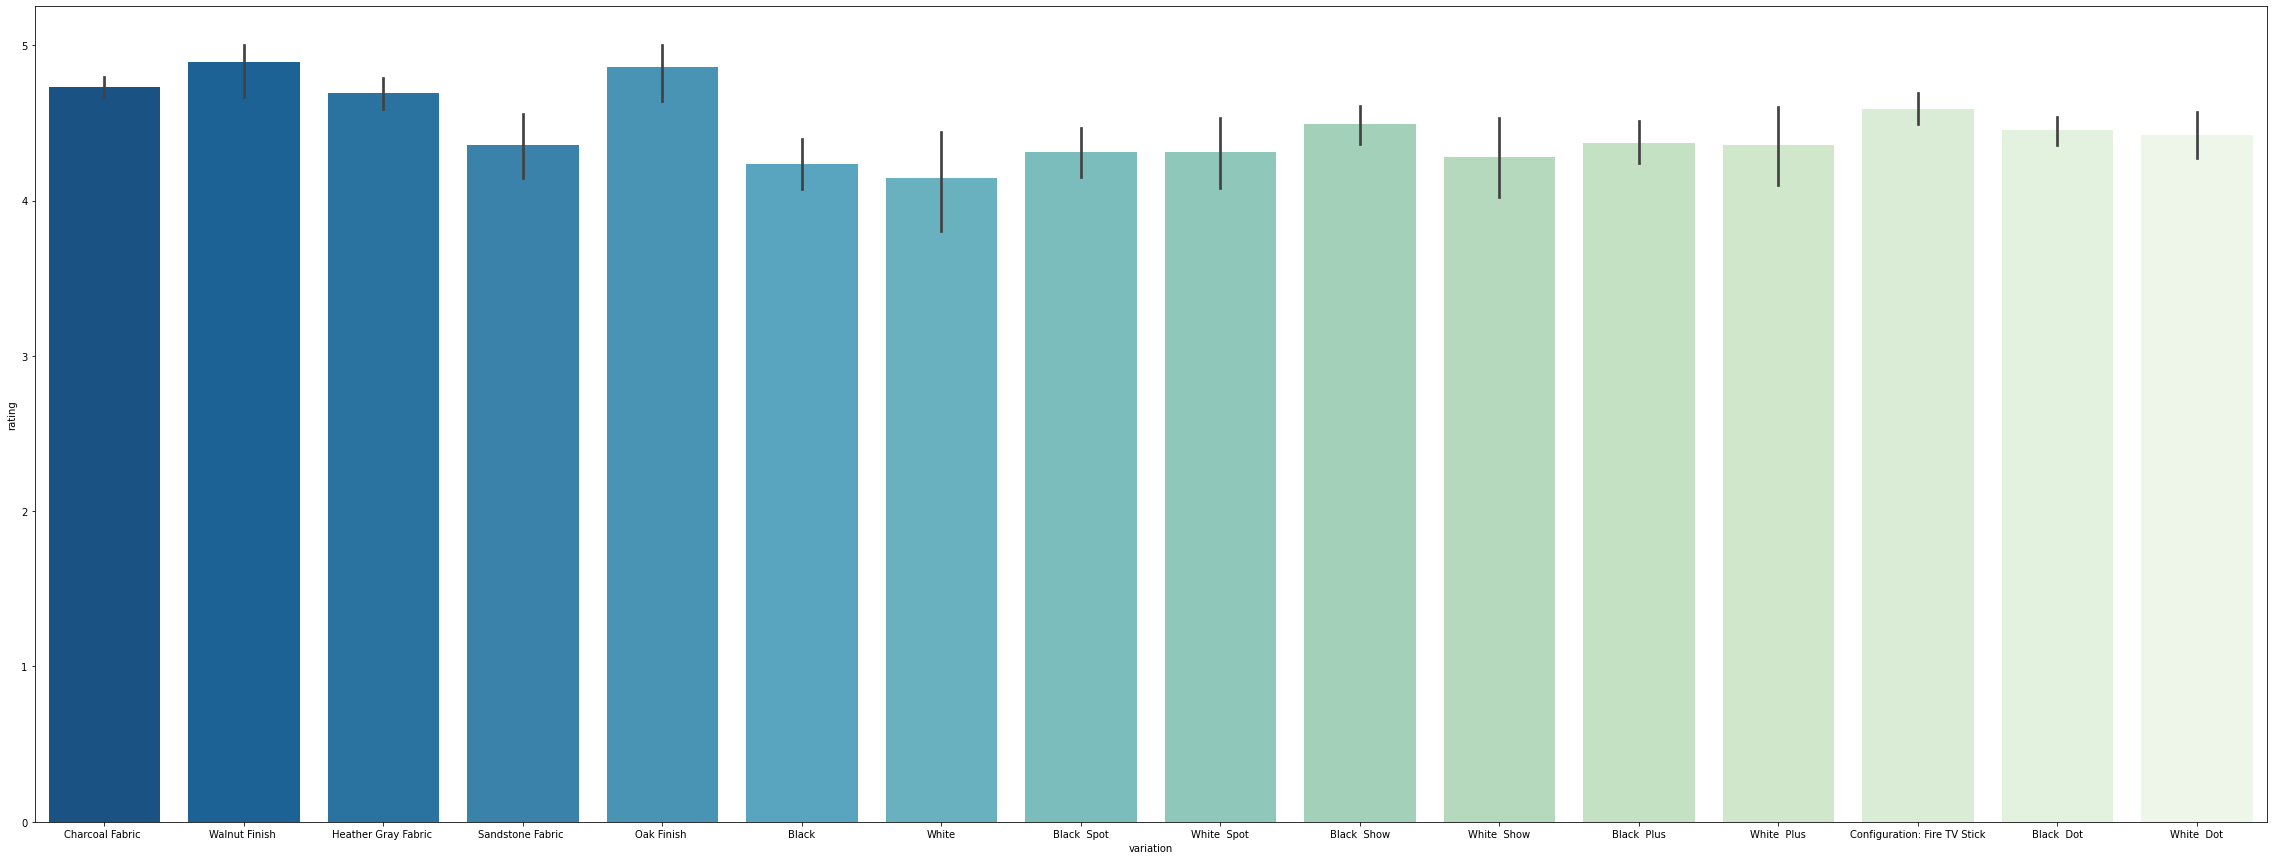

In [21]:
plt.figure(figsize=[40,15])
sns.barplot(x="variation", y="rating", data=df, palette="GnBu_r")


In [22]:
sentences = df["verified_reviews"].tolist()

In [23]:
sentences_one_string = " ".join(sentences)

In [24]:
sentences_one_string

'Love my Echo! Loved it! Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home. I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well. Music I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do. Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet. I think this is the 5th one I\'ve purchased. I\'m working on 

## Data cleaning

In [21]:
df.drop(columns=["rating", "date", "length"], axis = 1, inplace=True)

Necesitamos hacer los valores de "variation" 1 y 0 para el entrenamiento del modelo.

In [22]:
df_encode = pd.get_dummies(df["variation"], drop_first=True)

In [23]:
df_encode.head()

,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [24]:
df.drop(columns="variation", axis=1, inplace=True)

In [25]:
df.sample(3)

,verified_reviews,feedback
3131,Easy to set-up and to use.,1
390,"This was an add on for my echo system, the ref...",1
641,Love my echo dot!!!,1


Unimos los valores de "variation" con el dataset limpio

In [26]:
df_train = pd.concat([df, df_encode], axis=1)

In [27]:
df_train.head()

,verified_reviews,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,Love my Echo!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Loved it!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Sometimes while playing a game, you can answer...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,I have had a lot of fun with this thing. My 4 ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Music,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Pipeline

In [28]:
string.punctuation

def mes_filtering(comment):
    punc_remove = [char for char in comment if char not in string.punctuation]
    punc_remove_string = ''.join(punc_remove)
    stopwords_remove = [word for word in punc_remove_string.split() if word.lower() not in stopwords.words("english")]
    
    return stopwords_remove  

In [29]:
vectorizer = CountVectorizer(analyzer=mes_filtering)

reviews_countvectorizer = vectorizer.fit_transform(df_train["verified_reviews"])

In [30]:
print(vectorizer.get_feature_names_out())

['072318' '1' '10' ... '😬' '😳' '🤓']


In [31]:
df_train.drop(columns="verified_reviews", axis=1, inplace=True)

In [32]:
tokens = pd.DataFrame(reviews_countvectorizer.toarray())

In [33]:
df_token = pd.concat([df_train, tokens], axis = 1)

In [34]:
df_token.head()

,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,...,5201,5202,5203,5204,5205,5206,5207,5208,5209,5210
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
x = df_token.drop(columns="feedback", axis=1)
y = df_token["feedback"]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [41]:
nb_model = MultinomialNB()

In [48]:
nb_model.fit(X_train, y_train)

MultinomialNB()

In [49]:
y_predict_train = nb_model.predict(X_train)
y_predict_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

<AxesSubplot:>

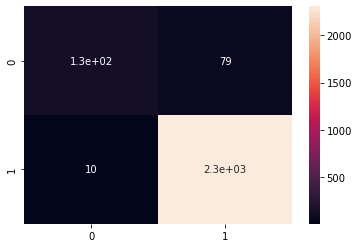

In [53]:
matrix = confusion_matrix(y_train, y_predict_train)
sns.heatmap(matrix, annot=True)

In [56]:
y_predict_test = nb_model.predict(X_test)

<AxesSubplot:>

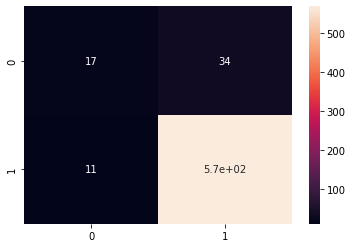

In [57]:
matrix = confusion_matrix(y_test, y_predict_test)
sns.heatmap(matrix, annot=True)

In [58]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.61      0.33      0.43        51
           1       0.94      0.98      0.96       579

    accuracy                           0.93       630
   macro avg       0.78      0.66      0.70       630
weighted avg       0.92      0.93      0.92       630

